In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [5]:
   
db = CaseDB()
toload = [
    dict(name="afnE_base", id = "d28a-d24bd_copy_cond0.25_frec0.48"),
    dict(name="afnE_base_1e19", id = "d26b-c0.25_f0.48_1e19"),
    dict(name="afnE_hirespol_1", id = "d31b-step1_slightly_finer_xpoint"),
    dict(name="afnE_hirespol_2", id = "d31c-step2_more_fine_xpoint"),
    dict(name="afnE_hiresrad_1", id = "d32a-radial_fine_xpoint1"),
    dict(name="afnE_hiresrad_2", id = "d32b-radial_fine_xpoint2"),
    dict(name="afnE_hiresrad_3", id = "d32c-radial_fine_xpoint3"),
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True)

- Reading case d28a-d24bd_copy_cond0.25_frec0.48
-----------------------
- Looking for squash file
- Squash file found. squash date 11/20/2023, 13:34:55, dmp file date 11/18/2023, 20:13:34

- Reading case d26b-c0.25_f0.48_1e19
-----------------------
- Looking for squash file
- Squashoutput file not found, creating...
- Done

- Reading case d31b-step1_slightly_finer_xpoint
-----------------------
- Looking for squash file
- Squash file found. squash date 12/04/2023, 10:12:27, dmp file date 12/03/2023, 14:20:57

- Reading case d31c-step2_more_fine_xpoint
-----------------------
- Looking for squash file
- Squash file found. squash date 12/04/2023, 10:13:37, dmp file date 12/03/2023, 13:59:29

- Reading case d32a-radial_fine_xpoint1
-----------------------
- Looking for squash file
- Squash file found. squash date 12/05/2023, 10:57:08, dmp file date 12/05/2023, 09:43:23

- Reading case d32b-radial_fine_xpoint2
-----------------------
- Looking for squash file
- Squash file found. squash 

In [ ]:
casest

In [63]:
hr = dict()
for name in casestore.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(casestore[name].ds.isel(t=-1, x = slice(2,-2)))
    
    if "afnE" in  name:
        new_afn = True
        print(f"Loading {name} with new AFN")
    else:
        new_afn = False
        print(f"Loading {name} with old AFN")
    
    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = new_afn)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

afnE_base
Loading afnE_base with new AFN
afnE_base_1e19
Loading afnE_base_1e19 with new AFN
afnE_hirespol_1
Loading afnE_hirespol_1 with new AFN
afnE_hirespol_2
Loading afnE_hirespol_2 with new AFN
afnE_hiresrad_1
Loading afnE_hiresrad_1 with new AFN
afnE_hiresrad_2
Loading afnE_hiresrad_2 with new AFN
afnE_hiresrad_3
Loading afnE_hiresrad_3 with new AFN


In [4]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

In [112]:
casestore.keys()

dict_keys(['afnE_base', 'afnE_base_1e19', 'afnE_hirespol_1', 'afnE_hirespol_2', 'afnE_hiresrad_1', 'afnE_hiresrad_2', 'afnE_hiresrad_3'])

## Look deeper into MC cases

In [114]:
case

'a'

C:\Users\mikek\AppData\Local\Temp\ipykernel_59064\2075143395.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))


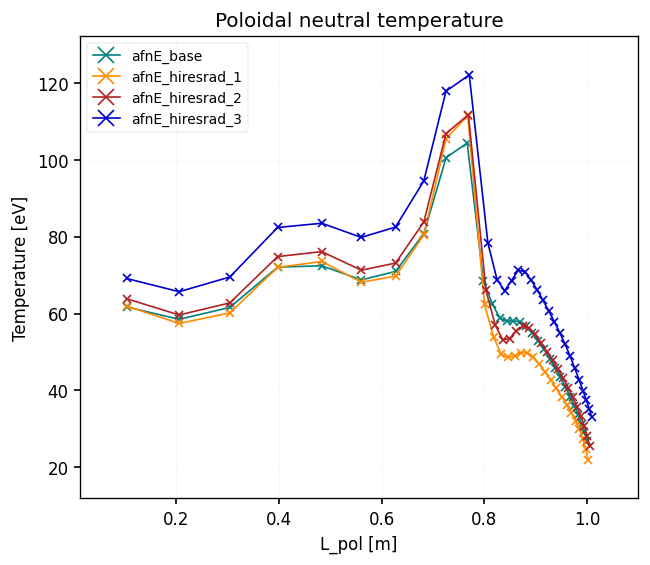

In [117]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']




for cases in [['afnE_base', 'afnE_hiresrad_1', 'afnE_hiresrad_2', 'afnE_hiresrad_3']]:
    colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
    fig, ax = plt.subplots(dpi = 120)

    for i, case in enumerate(cases):
        ds = casestore[case].ds.isel(t=-1)
        m = ds.metadata
        fl = ds.isel(x = m["ixseps1"], theta = slice(76,-2))
        dist = np.cumsum(fl["dl"])
        
        if any([x in case for x in ["form2", "form4"]]):
            m = "x"
        elif any([x in case for x in ["form1", "form3"]]):
            m = "+"
        else:
            m = "x"
        ax.plot(dist, fl["Td"], label = case, marker = m, ms = 5, lw = 1)
    # ax.set_yscale("symlog", linthresh = 1e-3)
    ax.set_xlabel("L_pol [m]")
    ax.set_ylabel("Temperature [eV]")
    ax.set_title("Poloidal neutral temperature")
    ax.legend(fontsize="small")

# Look at Td in all cases

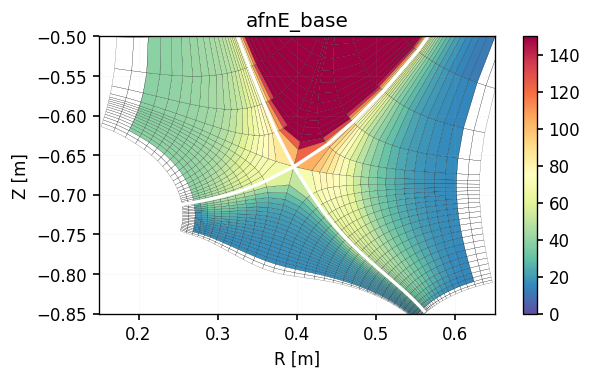

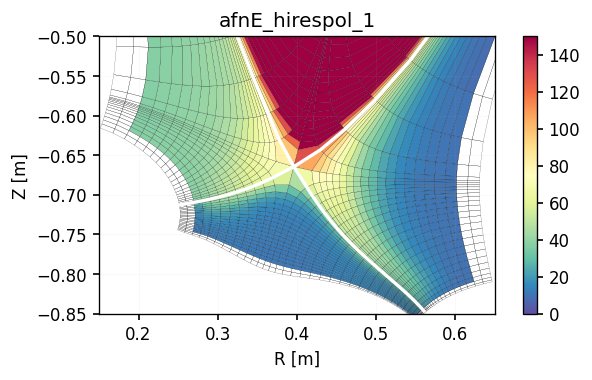

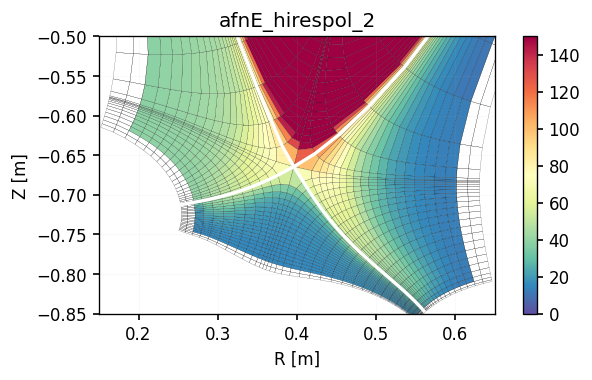

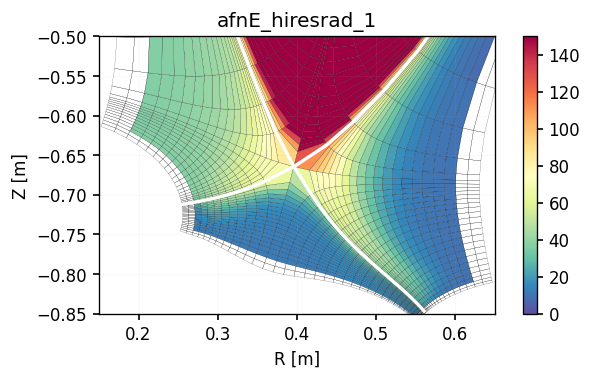

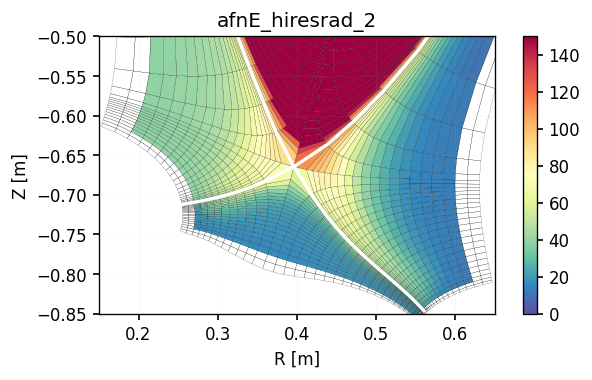

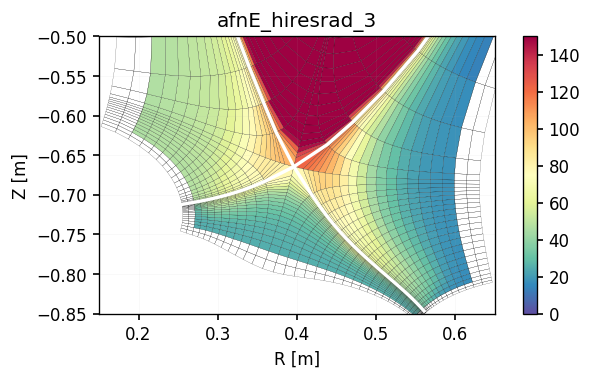

In [4]:
for case in [x for x in casestore.keys() if "notune" not in x]:
    fig, ax = plt.subplots(figsize = (6,3))
    ds = casestore[case].ds.isel(t=-1)
    ds["Td"].hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 150, vmin = 0, antialias = True, linewidth = 0.1)
    ax.set_ylim(-0.85, -0.5)
    ax.set_xlim(0.15,0.65)
    ax.set_title(case)

# Runtime

Text(0.5, 1.0, 'Simulation speed')

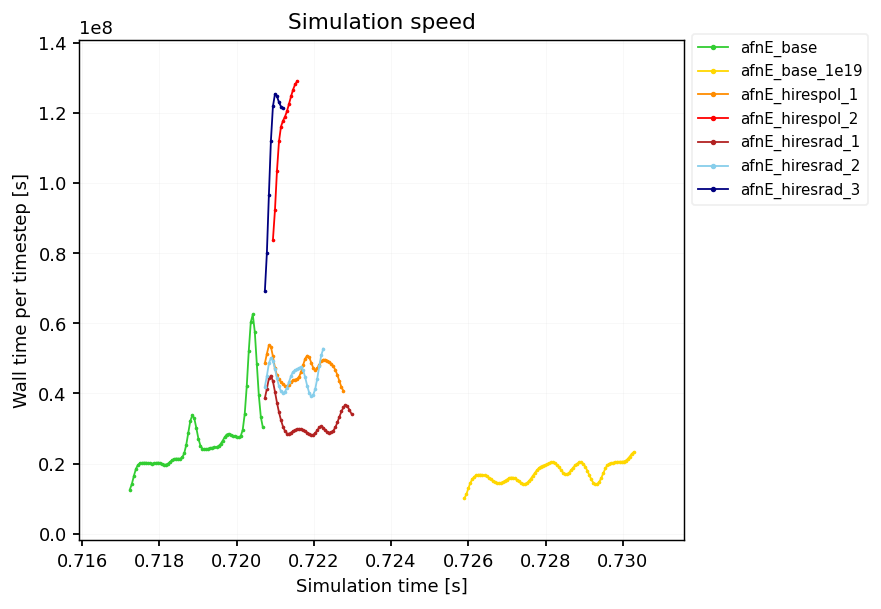

In [6]:
fig, ax = plt.subplots(dpi = 130)

colors = ["limegreen", "gold", "darkorange", "red", "firebrick", "skyblue", "navy"]

for i, case in enumerate(casestore):
    ds = casestore[case].ds
    wtime = ds["wtime"][:-1].values
    tstep = ds["t"].diff("t").values
    
    wtime_per_tstep = wtime/tstep
    time = ds["t"][:-1].values

    
    ax.plot(time, scipy.ndimage.gaussian_filter1d(wtime_per_tstep, 2), label = case, color = colors[i], lw = 1, marker = "o", ms = 1)
    
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Wall time per timestep [s]")
ax.set_title("Simulation speed")
# ax.set_xlim(None,0.614688)

# Search for trends in other profiles

In [13]:
fl["Td"].values

array([ 69.14510491,  65.69754709,  69.52099702,  82.4298709 ,
        83.53802006,  79.84503572,  82.54426717,  94.52963356,
       117.94214979, 122.19276845,  78.38197122,  68.86326256,
        65.93448136,  68.60832007,  71.30576334,  70.92978169,
        68.858762  ,  66.25835263,  63.47184335,  60.64428151,
        57.8102782 ,  54.93389651,  51.96146836,  48.87268959,
        45.74228028,  42.73268782,  39.9463659 ,  37.4250171 ,
        35.18870521,  33.13973249])

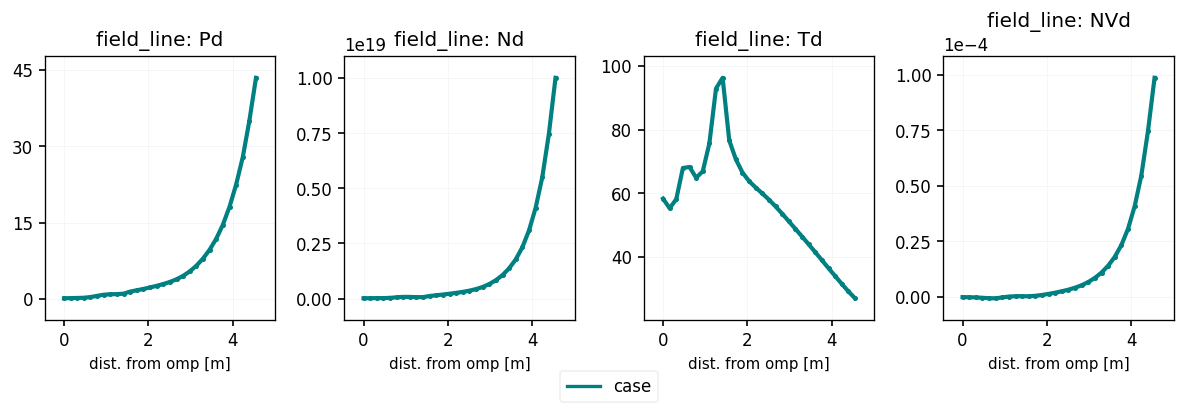

In [25]:
lineplot(
    {
        "case":casestore["afnE_base"].ds.isel(t=-1),
    },
    clean_guards = False,
    params = ["Pd", "Nd", "Td", "NVd"],
    regions = ["field_line"],
    logscale = False
)

In [ ]:
casestore["afnE_base"].ds["SPd"]

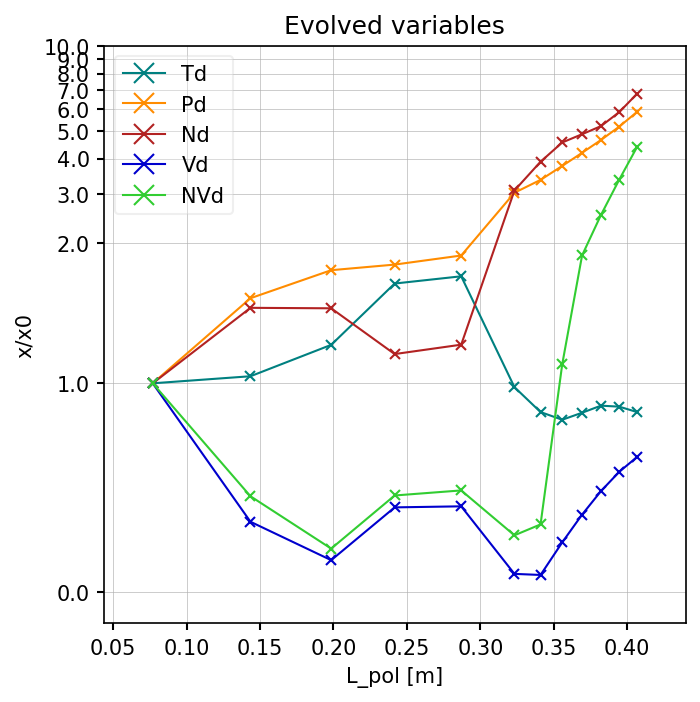

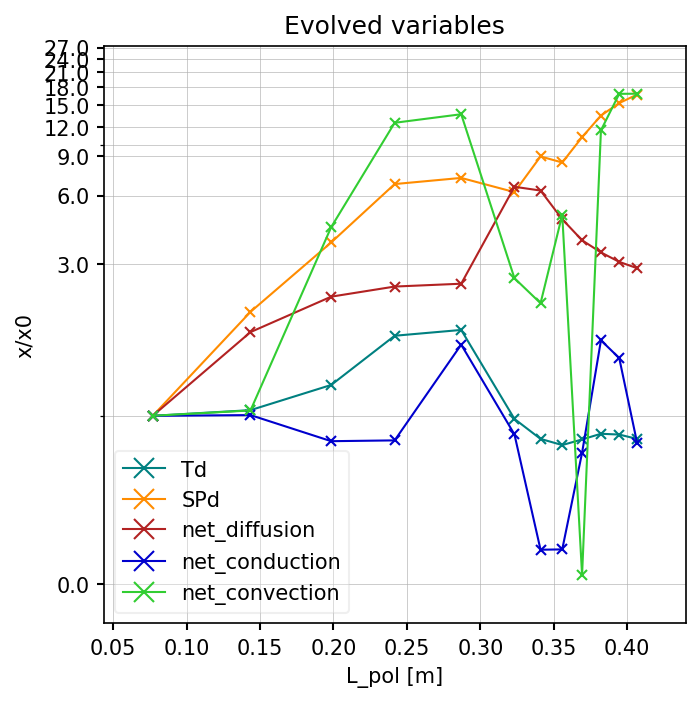

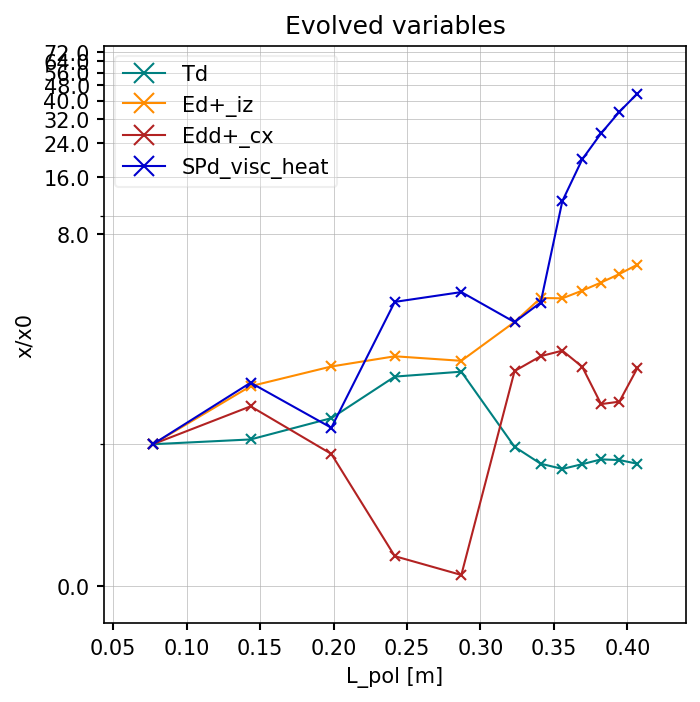

In [119]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']
ds = casestore[case].ds.isel(t=-1)
m = ds.metadata
# fl = ds.isel(x = m["ixseps1"], theta = slice(76,-2))
fl = ds.isel(x = m["ixseps1"], theta = slice(81,-15))
fl["Vd"] = fl["NVd"] / fl["Nd"] / (constants("mass_p")*2)

fl["net_diffusion"] = fl["pf_perp_diff_R_d"] - fl["pf_perp_diff_L_d"]
fl["net_conduction"] = fl["hf_perp_diff_R_d"] - fl["hf_perp_diff_L_d"]
fl["net_convection"] = fl["hf_perp_conv_R_d"] - fl["hf_perp_conv_L_d"]

for param_list in (
    ["Td", "Pd", "Nd", "Vd", "NVd"],
    ["Td", "SPd", "net_diffusion", "net_conduction", "net_convection"],
    ["Td", "Ed+_iz", "Edd+_cx", "SPd_visc_heat"],
):
    
    
    fig, ax = plt.subplots(figsize = (5,5), dpi = 150)

    
    dist = np.cumsum(fl["dl"]).values
    
    namedict = {"pf_perp_diff_R_d":"Perp diffusion", "hf_perp_diff_R_d":"Perp conduction", "hf_perp_conv_R_d":"Perp convection"}

    for param in param_list:
        
        if param in namedict:
            label = namedict[param]
        else:
            label = param
        
        ax.plot(dist, abs(fl[param]/fl[param][0]), label = label, marker = "x", ls = "-", ms = 5, lw = 1)
    ax.set_yscale("symlog", linthresh = 1.5)
    ax.set_xlabel("L_pol [m]")
    ax.set_ylabel("x/x0")
    ax.set_title("Evolved variables")
    ax.grid(which="both", alpha = 1)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=10,nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.1f}"))
    ax.legend()

## SPd breakdown

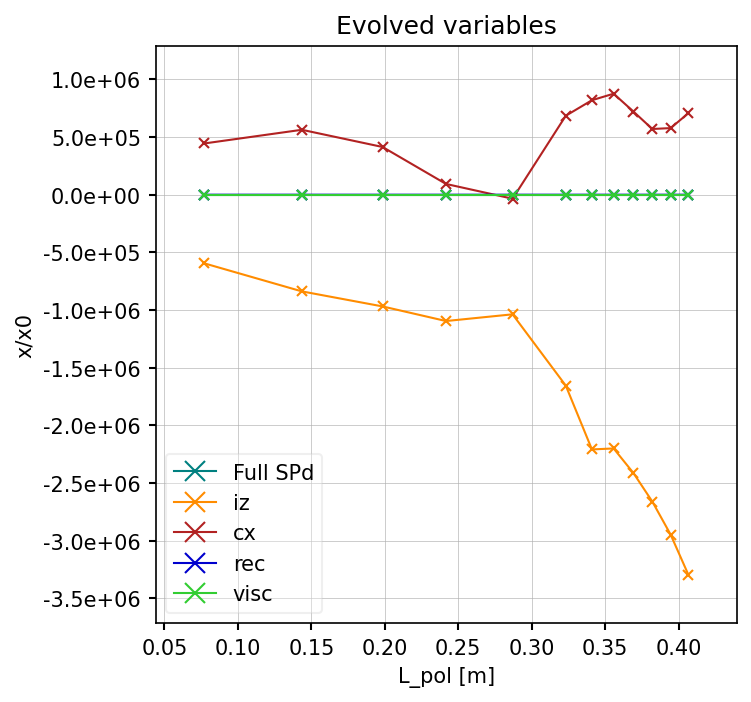

In [111]:
# locond = ['afnE', 'afnE_cond0.01', 'afnE_cond0.01_minmod_form1', 'afnE_cond0.01_minmod_form3', 'afnE_cond0.01_minmod_form2', 'afnE_cond0.25_form1', 'afnE_cond0.25_form2', 'afnE_cond0.25_form3', 'noafn_old', 'noafn_new']


    

fig, ax = plt.subplots(figsize = (5,5), dpi = 150)

ds = casestore[case].ds.isel(t=-1)
m = ds.metadata
# fl = ds.isel(x = m["ixseps1"], theta = slice(76,-2))
fl = ds.isel(x = m["ixseps1"], theta = slice(81,-15))
fl["Vd"] = fl["NVd"] / fl["Nd"] / (constants("mass_p")*2)
dist = np.cumsum(fl["dl"]).values

ax.plot(dist, fl["SPd"], label = "Full SPd", marker = "x", ls = "-", ms = 5, lw = 1)

def normalise(x):
    return abs(x/x[0])

c = {}
c["iz"] = fl["Ed+_iz"] * 2/3 * -1
c["cx"] = fl["Edd+_cx"] * 2/3
c["rec"] = fl["Ed+_rec"] * 2/3 
c["visc"] = fl["SPd_visc_heat"]
total = 0

for term in c:
    ax.plot(dist, c[term], label = term, marker = "x", ls = "-", ms = 5, lw = 1)
    total += c[term].values

# ax.plot(dist, normalise(total), label = "Sum of all terms", marker = "x", ls = "--", ms = 0, lw = 1, c = "black")

# ax.set_yscale("symlog", linthresh = 1e8)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("x/x0")
ax.set_title("Evolved variables")
ax.grid(which="both", alpha = 1)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=10,nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.1e}"))
ax.legend()